In [32]:
import gymnasium as gym
from gymnasium import spaces

# PyTorch imports
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

if torch.cuda.is_available():
  device = "cuda" 
else:
  device = "cpu"
print(device, " in use")

#torch.autograd.set_detect_anomaly(True)

# Utility librarues
import base64, io
import random
import pickle
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from itertools import count

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

cuda  in use


/tmp/ipykernel_4830/777588319.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [33]:
env = gym.make('CartPole-v1')

obs_space = 4
action_space = 2

debug = False

# Actor Network

In [34]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(obs_space, 128)
        self.hidden = nn.Linear(128, 64)
        self.out = nn.Linear(64, action_space) # action probabilities

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.hidden(x))
        action_prob = F.softmax(self.out(x), dim=-1) 
        if debug:
            print("Action Prob returned by actor model\n\t", action_prob)
            print("To check is action prob 1d or not \n")
        return action_prob


# Q Critic Network

In [35]:
class Q_Critic(nn.Module):
    def __init__(self):
        super(Q_Critic, self).__init__()
        self.layer1 = nn.Linear(obs_space + 1, 128)
        self.hidden = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1) # action probabilities

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.hidden(x))
        Q_val = self.out(x)
        return Q_val
    

class Q_Critic_2(nn.Module):
    def __init__(self):
        super(Q_Critic_2, self).__init__()
        self.layer1 = nn.Linear(obs_space + 1, 128)
        self.hidden = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1) # action probabilities

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.hidden(x))
        Q_val = self.out(x)
        return Q_val
    

# Utility Functions

In [36]:
def give_action(obs, Actor_model): # obs in numpy
    
    obs = torch.from_numpy(obs).float()
    probs = Actor_model(obs)
    dist = Categorical(probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)

    return action.item(), log_prob

def give_action_greedy(obs, Actor_model):
    obs = torch.from_numpy(obs).float()
    probs = Actor_model(obs)
    max_val , idx = torch.max(probs, dim = -1)

    return idx.cpu().detach().numpy()


In [39]:
def give_Qsa(obs, action, Qsa_model): # obs, action both in numpy
    action -= 0.5
    inp = np.concatenate((obs, [action]))
    inp = np.reshape(inp, -1)
    inp = torch.from_numpy(inp).float()
    
    Qval = Qsa_model(inp)

    return Qval

## Define Model

In [40]:
Actor_model = Actor()
Qsa_model = Q_Critic()

Qsa_model_2 = Q_Critic_2()

Actor_lr = 0.00001
Actor_optim = optim.Adam(Actor_model.parameters(), lr = Actor_lr)
Qsa_lr = 0.00001
Qsa_optim = optim.Adam(Qsa_model.parameters(), lr = Qsa_lr)

Qsa_model_2.load_state_dict(Qsa_model.state_dict())

max_itr = 600
gamma = 0.99
mini_batch = 2

In [41]:
max_itr_epi = []
reward_epi = []
avg_reward = []
itr = 0
running_reward = 0
C = 3

criterion = nn.MSELoss()

for cnt in count():

    itr += 1
    obs, info = env.reset()
    terminated, truncated = False, False
    ep_reward = 0

    for i in range(max_itr):
        
        expected = []
        predicted = []
        log_prob_arr = []
        tderr_arr = []
        ## Start of Algo
    
        action, log_prob = give_action(obs, Actor_model)  # action.item , log_prob from dist.log_prob 
        new_obs, reward, terminated, truncated, info = env.step(action)
        
        Qsa = give_Qsa(obs, action, Qsa_model)

        reward = reward - 10*abs(new_obs[2]) - 0.1*abs(new_obs[1]) - 0.1*abs(new_obs[3])

        if terminated or truncated:
            new_Qsa = torch.tensor([0.0], requires_grad= False)
        else:
            with torch.no_grad():
                new_action, _ = give_action(new_obs, Actor_model)
                new_Qsa = give_Qsa(new_obs, new_action, Qsa_model_2)

        exp = reward + gamma*new_Qsa
        tderr = exp - Qsa 

        expected.append(exp)
        predicted.append(Qsa)
        log_prob_arr.append(log_prob)
        tderr_arr.append(tderr)
        
        if i+1 % mini_batch == 0:

            expected_state_action_values = torch.tensor(expected, dtype=torch.float)
            predicted_state_action_values = torch.tensor(predicted, dtype=torch.float)
            log_probs = torch.tensor(log_prob_arr, dtype=torch.float)
            tderrs = torch.tensor(tderr_arr, dtype=torch.float)

            Critic_loss_T = torch.stack( (expected_state_action_values.detach() - predicted_state_action_values)**2 ).sum()
            Actor_loss_T = torch.stack( -log_probs*tderrs.detach() ).sum()
    
            Actor_optim.zero_grad()
            Actor_loss_T.backward()#retain_graph=True
            Actor_optim.step()

            Qsa_optim.zero_grad()
            Critic_loss_T.backward()
            Qsa_optim.step()

            expected = []
            predicted = []
            log_prob_arr = []
            tderr_arr = []
        
        if i+1%C == 0:
            Qsa_model_2.load_state_dict(Qsa_model.state_dict())

        obs = new_obs
        ep_reward += reward
        
        if truncated or terminated:
            max_itr_epi.append(i)
            reward_epi.append(ep_reward)
            break
    
    running_reward = 0.05 * ep_reward + (1-0.05) * running_reward
    avg_reward.append(running_reward)

    if itr% 100 == 0:
        plt.plot(max_itr_epi, label = 'itr/epi')
        plt.plot(reward_epi, label = 'rew/epi')
        plt.plot(avg_reward, label = 'avg_rew')
        plt.pause(0.001)

        display.display(plt.gcf())
        display.clear_output(wait=True)

    if cnt == 10000:
        break


<Figure size 800x550 with 0 Axes>

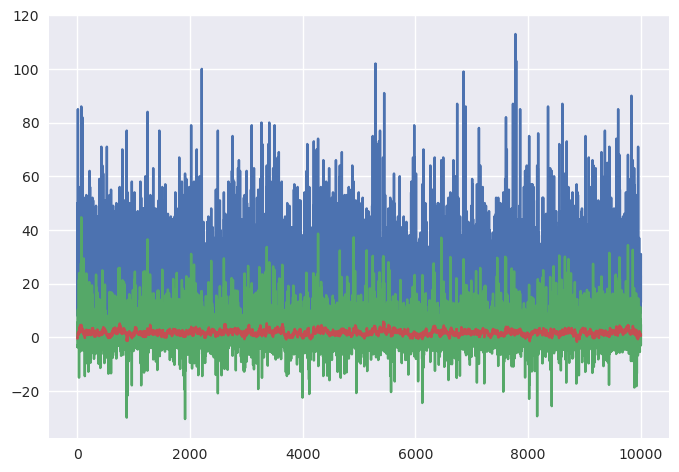

In [42]:
plt.plot(max_itr_epi, label = 'itr/epi')
plt.plot(reward_epi, label = 'rew/epi')
plt.plot(avg_reward, label = 'avg_rew')

# Backpropagation
# Actor_optim.zero_grad()
# Actor_loss_T = torch.stack(Actor_loss).sum()
# Actor_loss_T.backward()
# Actor_optim.step()

# Qsa_optim.zero_grad()
# Critic_loss_T = torch.stack(Critic_loss).sum()
# Critic_loss_T.backward()
# Qsa_optim.step()

    # if itr % 10 == 0: 
#     print("Episode {}\tLast Reward: {:.2f}\tAverage reward: {:.2f}".format(
#         itr, ep_reward, running_reward
#     ))

## Evaluation

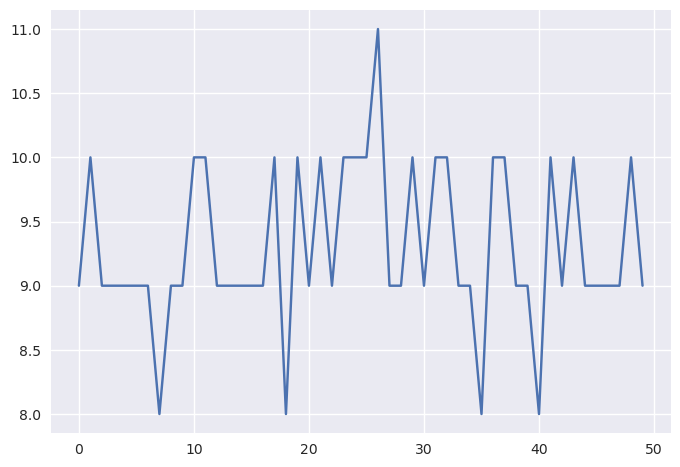

In [47]:
# There. we finished
# Lets see it in action
done = False
cnt = 0

env = gym.make('CartPole-v1', render_mode="human")

observation, info = env.reset()

reward_arr_eval = []

for i in range(50):
    observation, info = env.reset()
    done = False
    cnt = 0
    reward_ = 0
    while True:

        cnt += 1
        #env.render()
        action = give_action_greedy(observation, Actor_model)
        observation, reward, done, _, _ = env.step(action)
        # Lets see how long it lasts until failing
        reward_ += reward
        if done:
            break
    reward_arr_eval.append(reward_)
    #print(f"Game lasted {cnt} moves")

env.close()
plt.plot(reward_arr_eval)

In [ ]:
max_itr_epi = []
avg_reward = []
itr = 0
running_reward = 10
criterion = nn.MSELoss()
for cnt in count():

    itr += 1
    obs, info = env.reset()
    terminated, truncated = False, False

    ep_reward = 0
    for i in range(max_itr):
        Critic_loss_T = 0
        Actor_loss_T = 0

        Actor_loss = []
        Critic_loss = []

        action, log_prob = give_action(obs, Actor_model)
        Qsa = give_Qsa(obs, action, Qsa_model)

        new_obs, reward, terminated, truncated, info = env.step(action)
        reward = reward - abs(new_obs[2])

        if terminated or truncated:
            new_Qsa = torch.tensor([0.0])
        else:
            with torch.no_grad():
                new_action, new_log_prob = give_action(new_obs, Actor_model)
                new_Qsa = give_Qsa(new_obs, new_action, Qsa_model)

        exp = reward + gamma*new_Qsa
        tderr = reward + gamma*new_Qsa - Qsa 

        Critic_loss_T += (exp - Qsa).pow(2).mean()
        Actor_loss_T += -log_prob* tderr.detach() #critic_loss(log_prob, tderr.detach())
        
        if i % 4 == 0:
            Qsa_optim.zero_grad()
            Critic_loss_T.backward(retain_graph=True)  #retain_graph=True
            Qsa_optim.step()

            Actor_optim.zero_grad()
            Actor_loss_T.backward()
            Actor_optim.step()

            Critic_loss_T = []
            Actor_loss_T = []

        obs = new_obs
        ep_reward += reward
        
        if truncated or terminated:
            max_itr_epi.append(ep_reward)
            break
    
    running_reward = 0.05 * ep_reward + (1-0.05) * running_reward
    avg_reward.append(running_reward)

    # if itr % 10 == 0: 
    #     print("Episode {}\tLast Reward: {:.2f}\tAverage reward: {:.2f}".format(
    #         itr, ep_reward, running_reward
    #     ))
    if itr% 100 == 0:
        plt.plot(max_itr_epi)
        plt.plot(avg_reward)
        plt.pause(0.001)

        display.display(plt.gcf())
        display.clear_output(wait=True)

    # Backpropagation
    # Actor_optim.zero_grad()
    # Actor_loss_T = torch.stack(Actor_loss).sum()
    # Actor_loss_T.backward()
    # Actor_optim.step()

    # Qsa_optim.zero_grad()
    # Critic_loss_T = torch.stack(Critic_loss).sum()
    # Critic_loss_T.backward()
    # Qsa_optim.step()